# Categorizing and Tagging Words

Back in elementary school you learnt the difference between nouns, verbs, adjectives, and adverbs. These "word classes" are not just the idle invention of grammarians, but are useful categories for many language processing tasks. As we will see, they arise from simple analysis of the distribution of words in text. The goal of this chapter is to answer the following questions:

1. What are lexical categories and how are they used in natural language processing?
2. What is a good Python data structure for storing words and their categories?
3. How can we automatically tag each word of a text with its word class?

Along the way, we'll cover some fundamental techniques in NLP, including sequence labeling, n-gram models, backoff, and evaluation. These techniques are useful in many areas, and tagging gives us a simple context in which to present them. We will also see how tagging is the second step in the typical NLP pipeline, following tokenization.

The process of classifying words into their parts of speech and labeling them accordingly is known as part-of-speech tagging, POS-tagging, or simply tagging. Parts of speech are also known as word classes or lexical categories. The collection of tags used for a particular task is known as a tagset. Our emphasis in this chapter is on exploiting tags, and tagging text automatically.

## 1-Using a Tagger
A part-of-speech tagger, or POS-tagger, processes a sequence of words, and attaches a part of speech tag to each word (don't forget to import nltk):

In [3]:
import nltk
from nltk import word_tokenize


text = word_tokenize("And now for something completely different")

nltk.pos_tag(text)

[('And', 'CC'),
 ('now', 'RB'),
 ('for', 'IN'),
 ('something', 'NN'),
 ('completely', 'RB'),
 ('different', 'JJ')]

Here we see that and is CC, a coordinating conjunction; now and completely are RB, or adverbs; for is IN, a preposition; something is NN, a noun; and different is JJ, an adjective.

> NLTK provides documentation for each tag, which can be queried using the tag, e.g. nltk.help.upenn_tagset('RB'), or a regular expression, e.g.  nltk.help.upenn_tagset('NN.*'). Some corpora have README files with tagset documentation, see nltk.corpus.???.readme(), substituting in the name of the corpus.

Let's look at another example, this time including some homonyms:

In [4]:
text = word_tokenize("They refuse to permit us to obtain the refuse permit")

nltk.pos_tag(text)

[('They', 'PRP'),
 ('refuse', 'VBP'),
 ('to', 'TO'),
 ('permit', 'VB'),
 ('us', 'PRP'),
 ('to', 'TO'),
 ('obtain', 'VB'),
 ('the', 'DT'),
 ('refuse', 'NN'),
 ('permit', 'NN')]

Notice that refuse and permit both appear as a present tense verb (VBP) and a noun (NN). E.g. refUSE is a verb meaning "deny," while REFuse is a noun meaning "trash" (i.e. they are not homophones). Thus, we need to know which word is being used in order to pronounce the text correctly. (For this reason, text-to-speech systems usually perform POS-tagging.)

> Your Turn: Many words, like ski and race, can be used as nouns or verbs with no difference in pronunciation. Can you think of others? Hint: think of a commonplace object and try to put the word to before it to see if it can also be a verb, or think of an action and try to put the before it to see if it can also be a noun. Now make up a sentence with both uses of this word, and run the POS-tagger on this sentence.

Lexical categories like "noun" and part-of-speech tags like NN seem to have their uses, but the details will be obscure to many readers. You might wonder what justification there is for introducing this extra level of information. Many of these categories arise from superficial analysis the distribution of words in text. Consider the following analysis involving woman (a noun), bought (a verb), over (a preposition), and the (a determiner). The text.similar() method takes a word w, finds all contexts w1w w2, then finds all words w' that appear in the same context, i.e. w1w'w2.

In [5]:
text = nltk.Text(word.lower() for word in nltk.corpus.brown.words())

print(text.similar('woman'))
print(text.similar('bought'))
print(text.similar('over'))
print(text.similar('the'))

man time day year car moment world house family child country boy
state job place way war girl work word
None
made said done put had seen found given left heard was been brought
set got that took in told felt
None
in on to of and for with from at by that into as up out down through
is all about
None
a his this their its her an that our any all one these my in your no
some other and
None


Observe that searching for woman finds nouns; searching for bought mostly finds verbs; searching for over generally finds prepositions; searching for the finds several determiners. A tagger can correctly identify the tags on these words in the context of a sentence, e.g. The woman bought over 150,000 worth of clothes.

A tagger can also model our knowledge of unknown words, e.g. we can guess that scrobbling is probably a verb, with the root scrobble, and likely to occur in contexts like he was scrobbling.

## Tagged Corpora

#### Representing Tagged Tokens

By convention in NLTK, a tagged token is represented using a tuple consisting of the token and the tag. We can create one of these special tuples from the standard string representation of a tagged token, using the function str2tuple():

In [7]:
tagged_token = nltk.tag.str2tuple('fly/NN')

print(tagged_token)
print(tagged_token[0])
print(tagged_token[1])

('fly', 'NN')
fly
NN


In [8]:
sent = '''
    The/AT grand/JJ jury/NN commented/VBD on/IN a/AT number/NN of/IN
    other/AP topics/NNS ,/, AMONG/IN them/PPO the/AT Atlanta/NP and/CC
    Fulton/NP-tl County/NN-tl purchasing/VBG departments/NNS which/WDT it/PPS
    said/VBD ``/`` ARE/BER well/QL operated/VBN and/CC follow/VB generally/RB
    accepted/VBN practices/NNS which/WDT inure/VB to/IN the/AT best/JJT
    interest/NN of/IN both/ABX governments/NNS ''/'' ./.
    '''

[nltk.tag.str2tuple(t) for t in sent.split()]

[('The', 'AT'),
 ('grand', 'JJ'),
 ('jury', 'NN'),
 ('commented', 'VBD'),
 ('on', 'IN'),
 ('a', 'AT'),
 ('number', 'NN'),
 ('of', 'IN'),
 ('other', 'AP'),
 ('topics', 'NNS'),
 (',', ','),
 ('AMONG', 'IN'),
 ('them', 'PPO'),
 ('the', 'AT'),
 ('Atlanta', 'NP'),
 ('and', 'CC'),
 ('Fulton', 'NP-TL'),
 ('County', 'NN-TL'),
 ('purchasing', 'VBG'),
 ('departments', 'NNS'),
 ('which', 'WDT'),
 ('it', 'PPS'),
 ('said', 'VBD'),
 ('``', '``'),
 ('ARE', 'BER'),
 ('well', 'QL'),
 ('operated', 'VBN'),
 ('and', 'CC'),
 ('follow', 'VB'),
 ('generally', 'RB'),
 ('accepted', 'VBN'),
 ('practices', 'NNS'),
 ('which', 'WDT'),
 ('inure', 'VB'),
 ('to', 'IN'),
 ('the', 'AT'),
 ('best', 'JJT'),
 ('interest', 'NN'),
 ('of', 'IN'),
 ('both', 'ABX'),
 ('governments', 'NNS'),
 ("''", "''"),
 ('.', '.')]

#### Reading Tagged Corpora
Several of the corpora included with NLTK have been tagged for their part-of-speech. Here's an example of what you might see if you opened a file from the Brown Corpus with a text editor:

> The/at Fulton/np-tl County/nn-tl Grand/jj-tl Jury/nn-tl said/vbd Friday/nr an/at investigation/nn of/in Atlanta's/npS recent/jj primary/nn election/nn produced/vbd / no/at evidence/nn ''/'' that/cs any/dti irregularities/nns took/vbd place/nn ./.

Other corpora use a variety of formats for storing part-of-speech tags. NLTK's corpus readers provide a uniform interface so that you don't have to be concerned with the different file formats. In contrast with the file fragment shown above, the corpus reader for the Brown Corpus represents the data as shown below. Note that part-of-speech tags have been converted to uppercase, since this has become standard practice since the Brown Corpus was published.

In [10]:
print(nltk.corpus.brown.tagged_words())

print(nltk.corpus.brown.tagged_words(tagset='universal'))

[('The', 'AT'), ('Fulton', 'NP-TL'), ...]
[('The', 'DET'), ('Fulton', 'NOUN'), ...]


In [11]:
# Whenever a corpus contains tagged text, the NLTK corpus interface will have a 
#tagged_words() method. Here are some more examples, again using the output format 
#illustrated for the Brown Corpus:

print(nltk.corpus.nps_chat.tagged_words())

print(nltk.corpus.conll2000.tagged_words())

print(nltk.corpus.treebank.tagged_words())

[('now', 'RB'), ('im', 'PRP'), ('left', 'VBD'), ...]
[('Confidence', 'NN'), ('in', 'IN'), ('the', 'DT'), ...]
[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ...]


In [12]:
# Not all corpora employ the same set of tags; see the tagset help functionality and the 
#readme() methods mentioned above for documentation. Initially we want to avoid the complications 
#of these tagsets, so we use a built-in mapping to the "Universal Tagset":

print(nltk.corpus.brown.tagged_words(tagset='universal'))

print(nltk.corpus.treebank.tagged_words(tagset='universal'))

[('The', 'DET'), ('Fulton', 'NOUN'), ...]
[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ...]


In [13]:
# Tagged corpora for several other languages are distributed with NLTK, including Chinese, 
#Hindi, Portuguese, Spanish, Dutch and Catalan. These usually contain non-ASCII text, and 
#Python always displays this in hexadecimal when printing a larger structure such as a list.

print(nltk.corpus.sinica_treebank.tagged_words())
print(nltk.corpus.indian.tagged_words())
print(nltk.corpus.mac_morpho.tagged_words())
print(nltk.corpus.conll2002.tagged_words())
print(nltk.corpus.cess_cat.tagged_words())

[('一', 'Neu'), ('友情', 'Nad'), ('嘉珍', 'Nba'), ...]
[('মহিষের', 'NN'), ('সন্তান', 'NN'), (':', 'SYM'), ...]
[('Jersei', 'N'), ('atinge', 'V'), ('média', 'N'), ...]
[('Sao', 'NC'), ('Paulo', 'VMI'), ('(', 'Fpa'), ...]
[('El', 'da0ms0'), ('Tribunal_Suprem', 'np0000o'), ...]


### A Universal Part-of-Speech Tagset
Tagged corpora use many different conventions for tagging words. To help us get started, we will be looking at a simplified tagset below.

#### Universal Part-of-Speech Tagset

| Tag |	Meaning | English Examples |
|----|----|----|
|ADJ	|adjective	| new, good, high, special, big, local |
|ADP	|adposition	| on, of, at, with, by, into, under |
|ADV	|adverb	| really, already, still, early, now |
|CONJ	|conjunction	| and, or, but, if, while, although |
|DET	|determiner, article	| the, a, some, most, every, no, which |
|NOUN	|noun	| year, home, costs, time, Africa |
|NUM	|numeral	| twenty-four, fourth, 1991, 14:24 |
|PRT	|particle	| at, on, out, over per, that, up, with |
|PRON	|pronoun	| he, their, her, its, my, I, us |
|VERB	|verb	| is, say, told, given, playing, would |
|.	|punctuation marks	| . , ; ! |
|X	|other	| ersatz, esprit, dunno, gr8, univeristy |

Let's see which of these tags are the most common in the news category of the Brown corpus:

In [14]:
from nltk.corpus import brown
brown_news_tagged = brown.tagged_words(categories='news', tagset='universal')
tag_fd = nltk.FreqDist(tag for (word, tag) in brown_news_tagged)
tag_fd.most_common()

[('NOUN', 30654),
 ('VERB', 14399),
 ('ADP', 12355),
 ('.', 11928),
 ('DET', 11389),
 ('ADJ', 6706),
 ('ADV', 3349),
 ('CONJ', 2717),
 ('PRON', 2535),
 ('PRT', 2264),
 ('NUM', 2166),
 ('X', 92)]

> Plot the above frequency distribution using tag_fd.plot(cumulative=True). What percentage of words are tagged using the first five tags of the above list?

We can use these tags to do powerful searches using a graphical POS-concordance tool nltk.app.concordance(). Use it to search for any combination of words and POS tags, e.g. N N N N,  hit/VD, hit/VN, or the ADJ man.

### Nouns
Nouns generally refer to people, places, things, or concepts, e.g.: woman, Scotland, book, intelligence. Nouns can appear after determiners and adjectives, and can be the subject or object of the verb, as shown in 2.2.

Syntactic Patterns involving some Nouns

| Word	| After a determiner	| Subject of the verb |
|----|----|----|
| woman	| the woman who I saw yesterday ...	| the woman sat down |
| Scotland	| the Scotland I remember as a child ...	| Scotland has five million people |
| book	| the book I bought yesterday ...	| this book recounts the colonization of Australia |
| intelligence	| the intelligence displayed by the child ...	| Mary's intelligence impressed her teachers |

The simplified noun tags are N for common nouns like book, and NP for proper nouns like Scotland.

Let's inspect some tagged text to see what parts of speech occur before a noun, with the most frequent ones first. To begin with, we construct a list of bigrams whose members are themselves word-tag pairs such as (('The', 'DET'), ('Fulton', 'NP')) and  (('Fulton', 'NP'), ('County', 'N')). Then we construct a FreqDist from the tag parts of the bigrams.

In [15]:
word_tag_pairs = nltk.bigrams(brown_news_tagged)
noun_preceders = [a[1] for (a, b) in word_tag_pairs if b[1] == 'NOUN']
fdist = nltk.FreqDist(noun_preceders)
[tag for (tag, _) in fdist.most_common()]

['NOUN',
 'DET',
 'ADJ',
 'ADP',
 '.',
 'VERB',
 'CONJ',
 'NUM',
 'ADV',
 'PRT',
 'PRON',
 'X']

This confirms our assertion that nouns occur after determiners and adjectives, including numeral adjectives (tagged as NUM).

 Verbs
Verbs are words that describe events and actions, e.g. fall, eat in 2.3. In the context of a sentence, verbs typically express a relation involving the referents of one or more noun phrases.

Table 2.3:

Syntactic Patterns involving some Verbs

| Word	| Simple	| With modifiers and adjuncts (italicized) |
|----|----|----|
| fall	| Rome fell	| Dot com stocks suddenly fell like a stone |
| eat	| Mice eat cheese	| John ate the pizza with gusto |

What are the most common verbs in news text? Let's sort all the verbs by frequency:

In [16]:
wsj = nltk.corpus.treebank.tagged_words(tagset='universal')
word_tag_fd = nltk.FreqDist(wsj)
[wt[0] for (wt, _) in word_tag_fd.most_common() if wt[1] == 'VERB']

['is',
 'said',
 'was',
 'are',
 'be',
 'has',
 'have',
 'will',
 'says',
 'would',
 'were',
 'had',
 'been',
 'could',
 "'s",
 'can',
 'do',
 'say',
 'make',
 'may',
 'did',
 'rose',
 'made',
 'does',
 'expected',
 'buy',
 'take',
 'get',
 'might',
 'sell',
 'added',
 'sold',
 'help',
 'including',
 'should',
 'reported',
 'according',
 'pay',
 'compared',
 'being',
 'fell',
 'began',
 'based',
 'used',
 'closed',
 "'re",
 'want',
 'see',
 'took',
 'yield',
 'offered',
 'set',
 'priced',
 'approved',
 'come',
 'noted',
 'cut',
 'ended',
 'found',
 'increased',
 'become',
 'think',
 'named',
 'go',
 'trying',
 'proposed',
 'received',
 'growing',
 'declined',
 'held',
 'give',
 'came',
 'use',
 'put',
 'making',
 'continue',
 'raise',
 'estimated',
 'called',
 'paid',
 'designed',
 'going',
 'expects',
 'seeking',
 'must',
 'plans',
 'wo',
 'increasing',
 'saying',
 'got',
 'owns',
 'trading',
 'acquired',
 'gained',
 'fined',
 'reached',
 'holding',
 'announced',
 'filed',
 'became',


Note that the items being counted in the frequency distribution are word-tag pairs. Since words and tags are paired, we can treat the word as a condition and the tag as an event, and initialize a conditional frequency distribution with a list of condition-event pairs. This lets us see a frequency-ordered list of tags given a word:

In [25]:
cfd1 = nltk.ConditionalFreqDist(wsj)

print(cfd1['yield'].most_common())
print(cfd1['cut'].most_common())

[('VB', 28), ('NN', 20)]
[('VB', 12), ('VBD', 10), ('VBN', 3), ('NN', 3)]


In [26]:
# We can reverse the order of the pairs, so that the tags are the conditions, and the words are 
# the events. Now we can see likely words for a given tag. We will do this for the WSJ tagset 
# rather than the universal tagset:
wsj = nltk.corpus.treebank.tagged_words()
cfd2 = nltk.ConditionalFreqDist((tag, word) for (word, tag) in wsj)
list(cfd2['VBN'])

['named',
 'used',
 'caused',
 'exposed',
 'reported',
 'replaced',
 'sold',
 'died',
 'expected',
 'diagnosed',
 'studied',
 'industrialized',
 'owned',
 'found',
 'classified',
 'rejected',
 'outlawed',
 'imported',
 'tracked',
 'thought',
 'considered',
 'elected',
 'based',
 'lifted',
 'ensnarled',
 'voted',
 'been',
 'held',
 'banned',
 'renovated',
 'prolonged',
 'recorded',
 'accumulated',
 'offered',
 'become',
 'guaranteed',
 'proposed',
 'related',
 'improved',
 'worried',
 'cluttered',
 'expedited',
 'retired',
 'ordered',
 'collected',
 'required',
 'received',
 'moved',
 'determined',
 'made',
 'changed',
 'completed',
 'disputed',
 'refunded',
 'estimated',
 'compared',
 'located',
 'filed',
 'scrapped',
 'anticipated',
 'priced',
 'set',
 'applied',
 'existed',
 'incurred',
 'reached',
 'Regarded',
 'paid',
 'trained',
 'instituted',
 'vowed',
 'deemed',
 'combined',
 'removed',
 'concerned',
 'complained',
 'accelerated',
 'believed',
 'called',
 'solved',
 'forgiven',


In [27]:
# To clarify the distinction between VBD (past tense) and VBN (past participle), let's find words which can be both VBD and VBN, and see 
# some surrounding text:

[w for w in cfd1.conditions() if 'VBD' in cfd1[w] and 'VBN' in cfd1[w]]

['named',
 'used',
 'caused',
 'reported',
 'said',
 'stopped',
 'heard',
 'studied',
 'led',
 'replaced',
 'sold',
 'worked',
 'died',
 'found',
 'rejected',
 'imposed',
 'made',
 'dumped',
 'imported',
 'mixed',
 'described',
 'continued',
 'ended',
 'thought',
 'reached',
 'had',
 'approved',
 'completed',
 'suspended',
 'lifted',
 'dropped',
 'voted',
 'settled',
 'decided',
 'followed',
 'welcomed',
 'held',
 'banned',
 'pointed',
 'squeezed',
 'fed',
 'registered',
 'released',
 'increased',
 'forecast',
 'recorded',
 'announced',
 'offered',
 'lowered',
 'spent',
 'proposed',
 'got',
 'added',
 'noted',
 'turned',
 'closed',
 'retired',
 'ordered',
 'required',
 'received',
 'moved',
 'determined',
 'changed',
 'upheld',
 'set',
 'estimated',
 'compared',
 'opened',
 'tied',
 'filed',
 'disclosed',
 'anticipated',
 'attached',
 'called',
 'applied',
 'favored',
 'posted',
 'paid',
 'removed',
 'accelerated',
 'placed',
 'vowed',
 'deemed',
 'prompted',
 'complained',
 'believed'

In [28]:
idx1 = wsj.index(('kicked', 'VBD'))
wsj[idx1-4:idx1+1]

[('While', 'IN'),
 ('program', 'NN'),
 ('trades', 'NNS'),
 ('swiftly', 'RB'),
 ('kicked', 'VBD')]

In [29]:
idx2 = wsj.index(('kicked', 'VBN'))
wsj[idx2-4:idx2+1]

[('head', 'NN'),
 ('of', 'IN'),
 ('state', 'NN'),
 ('has', 'VBZ'),
 ('kicked', 'VBN')]

In this case, we see that the past participle of kicked is preceded by a form of the auxiliary verb have. Is this generally true?

Adjectives and Adverbs
Two other important word classes are adjectives and adverbs. Adjectives describe nouns, and can be used as modifiers (e.g. large in the large pizza), or in predicates (e.g. the pizza is large). English adjectives can have internal structure (e.g. fall+ing in the falling stocks). Adverbs modify verbs to specify the time, manner, place or direction of the event described by the verb (e.g. quickly in the stocks fell quickly). Adverbs may also modify adjectives (e.g. really in Mary's teacher was really nice).

English has several categories of closed class words in addition to prepositions, such as articles (also often called determiners) (e.g., the, a), modals (e.g., should, may), and personal pronouns (e.g., she, they). Each dictionary and grammar classifies these words differently.

> If you are uncertain about some of these parts of speech, study them using nltk.app.concordance(), or watch some of the Schoolhouse Rock! grammar videos available at YouTube, or consult the Further Reading section at the end of this chapter.

### Unsimplified Tags

Let's find the most frequent nouns of each noun part-of-speech type. The program in 2.2 finds all tags starting with NN, and provides a few example words for each one. You will see that there are many variants of NN; the most important contain $ for possessive nouns, S for plural nouns (since plural nouns typically end in s) and P for proper nouns. In addition, most of the tags have suffix modifiers: -NC for citations, -HL for words in headlines and -TL for titles (a feature of Brown tabs).

In [30]:
def findtags(tag_prefix, tagged_text):
    cfd = nltk.ConditionalFreqDist((tag, word) for (word, tag) in tagged_text
                                  if tag.startswith(tag_prefix))
    return dict((tag, cfd[tag].most_common(5)) for tag in cfd.conditions())

tagdict = findtags('NN', nltk.corpus.brown.tagged_words(categories='news'))

for tag in sorted(tagdict):
    print(tag, tagdict[tag])

NN [('year', 137), ('time', 97), ('state', 88), ('week', 85), ('man', 72)]
NN$ [("year's", 13), ("world's", 8), ("state's", 7), ("nation's", 6), ("city's", 6)]
NN$-HL [("Golf's", 1), ("Navy's", 1)]
NN$-TL [("President's", 11), ("Administration's", 3), ("Army's", 3), ("League's", 3), ("University's", 3)]
NN-HL [('sp.', 2), ('problem', 2), ('Question', 2), ('cut', 2), ('party', 2)]
NN-NC [('ova', 1), ('eva', 1), ('aya', 1)]
NN-TL [('President', 88), ('House', 68), ('State', 59), ('University', 42), ('City', 41)]
NN-TL-HL [('Fort', 2), ('Mayor', 1), ('Commissioner', 1), ('City', 1), ('Oak', 1)]
NNS [('years', 101), ('members', 69), ('people', 52), ('sales', 51), ('men', 46)]
NNS$ [("children's", 7), ("women's", 5), ("men's", 3), ("janitors'", 3), ("taxpayers'", 2)]
NNS$-HL [("Dealers'", 1), ("Idols'", 1)]
NNS$-TL [("Women's", 4), ("States'", 3), ("Giants'", 2), ("Princes'", 1), ("Bombers'", 1)]
NNS-HL [('Wards', 1), ('deputies', 1), ('bonds', 1), ('aspects', 1), ('Decisions', 1)]
NNS-TL [

#### Exploring Tagged Corpora
Let's briefly return to the kinds of exploration of corpora we saw in previous chapters, this time exploiting POS tags.

Suppose we're studying the word often and want to see how it is used in text. We could ask to see the words that follow often

In [31]:
brown_learned_text = brown.words(categories='learned')
sorted(set(b for (a, b) in nltk.bigrams(brown_learned_text) if a == 'often'))

[',',
 '.',
 'accomplished',
 'analytically',
 'appear',
 'apt',
 'associated',
 'assuming',
 'became',
 'become',
 'been',
 'began',
 'call',
 'called',
 'carefully',
 'chose',
 'classified',
 'colorful',
 'composed',
 'contain',
 'differed',
 'difficult',
 'encountered',
 'enough',
 'equate',
 'extremely',
 'found',
 'happens',
 'have',
 'ignored',
 'in',
 'involved',
 'more',
 'needed',
 'nightly',
 'observed',
 'of',
 'on',
 'out',
 'quite',
 'represent',
 'responsible',
 'revamped',
 'seclude',
 'set',
 'shortened',
 'sing',
 'sounded',
 'stated',
 'still',
 'sung',
 'supported',
 'than',
 'to',
 'when',
 'work']

In [32]:
# However, it's probably more instructive use the tagged_words() method to look at the 
# part-of-speech tag of the following words:

brown_lrnd_tagged = brown.tagged_words(categories='learned', tagset='universal')
tags = [b[1] for (a, b) in nltk.bigrams(brown_lrnd_tagged) if a[0] == 'often']
fd = nltk.FreqDist(tags)
fd.tabulate()

VERB  ADV  ADP  ADJ    .  PRT 
  37    8    7    6    4    2 


Notice that the most high-frequency parts of speech following often are verbs. Nouns never appear in this position (in this particular corpus).

Next, let's look at some larger context, and find words involving particular sequences of tags and words (in this case "**Verb** to **Verb**"). In code-three-word-phrase we consider each three-word window in the sentence [1], and check if they meet our criterion [2]. If the tags match, we print the corresponding words [3].

> Open the POS concordance tool nltk.app.concordance() and load the complete Brown Corpus (simplified tagset). Now pick some of the above words and see how the tag of the word correlates with the context of the word. E.g. search for near to see all forms mixed together, near/ADJ to see it used as an adjective, near N to see just those cases where a noun follows, and so forth. For a larger set of examples, modify the supplied code so that it lists words having three distinct tags.

In [33]:
from nltk.corpus import brown

def process(sentence):
    for (w1,t1), (w2,t2), (w3,t3) in nltk.trigrams(sentence): #[1]
        if (t1.startswith('V') and t2 == 'TO' and t3.startswith('V')): #[2]
            print(w1, w2, w3) #[3]
            
for tagged_sent in brown.tagged_sents():
    process(tagged_sent)

combined to achieve
continue to place
serve to protect
wanted to wait
allowed to place
expected to become
expected to approve
expected to make
intends to make
seek to set
like to see
designed to provide
get to hear
expects to tell
expected to give
prefer to pay
required to obtain
permitted to teach
designed to reduce
Asked to elaborate
got to go
raised to pay
scheduled to go
cut to meet
needed to meet
hastened to add
found to prevent
continue to insist
compelled to make
made to remove
revamped to give
want to risk
appear to spark
fails to consider
plans to call
going to examine
plans to name
come to pass
voted to accept
happens to hold
authorized to adopt
hesitated to prosecute
try to make
decided to spend
taken to preserve
left to preserve
stand to bring
decided to seek
trying to induce
proposing to make
decided to run
directed to investigate
expected to pass
expected to make
expected to encounter
hopes to pass
came to pay
expected to receive
understood to follow
wanted to vote
decide

poised to strike
try to force
attempting to reach
afford to take
forbidden to sit
plans to import
likes to imagine
used to get
trying to make
ceased to suggest
going to work
wanting to cut
choose to persuade
trying to keep
like to embark
suited to defeat
hastened to put
like to add
want to preserve
required to participate
happened to save
doing to promote
tempted to quote
continuing to capture
need to communicate
like to see
interested to know
allowed to rust
chose to devote
left to choose
want to own
plan to become
persuaded to restock
seems to improve
arranged to permit
seem to lend
allowed to mix
starts to swing
seems to stop
ordered to hold
fitted to endure
trying to follow
threatening to explode
rides to break
managed to make
dancing to display
hasten to report
seems to come
reassuring to see
profess to know
help to explain
forced to rely
attempt to homogenize
like to put
continue to try
try to come
seem to deal
decide to let
tries to take
trying to forget
trying to acquire
threat

learn to portray
learn to portray
began to advise
taught to yield
prefer to cope
helps to explain
surprised to bump
seemed to brave
begins to regard
began to embezzle
appears to endorse
expected to like
begin to assert
began to challenge
going to become
helping to make
began to stress
began to describe
fails to gain
liked to play
love to audition
wanted to show
like to see
loved to dance
try to bid
wanted to go
asked to leave
continued to promote
wished to meet
hoping to see
got to know
paused to comfort
hesitate to quote
decided to see
wanted to take
need to know
need to look
beginning to protrude
try to speak
decides to proceed
interested to hear
seems to probe
preferring to consider
known to go
amazed to realize
seeking to help
interpreted to conform
explored to find
trying to throw
designed to find
required to mark
asked to consider
seem to involve
seems to smell
seems to see
learned to develop
arranged to meet
need to work
want to raise
need to bring
expect to grow
expected to wor

decided to stop
scheduled to become
seek to assure
agrees to furnish
prepared to consider
prepared to act
prepared to act
required to cease
required to operate
designed to operate
permitted to operate
taken to minimize
permitted to operate
permitted to operate
permitted to operate
required to operate
required to afford
elect to use
required to file
required to file
elect to use
required to file
obligated to furnish
trained to read
made to assure
tend to create
rejoicing to remember
permitted to run
came to work
decided to bring
found to permit
helping to strengthen
began to ship
believed to provide
designed to provide
expect to make
developed to facilitate
set to hold
continuing to carry
designed to increase
improved to obtain
purchased to permit
extended to provide
sought to meet
designed to handle
invited to participate
planned to provide
inclined to advance
aims to give
wish to pursue
expected to increase
expected to exceed
begun to make
continues to expand
began to make
need to lea

combine to create
learned to use
began to take
wanted to tell
wanted to substitute
want to make
come to determine
begun to ebb
intended to incorporate
led to postulate
hope to discover
tended to emphasize
fails to explore
seeks to make
helping to define
trying to avoid
trying to get
made to symbolize
kneels to kiss
serve to travesty
used to equate
altered to show
altered to show
taken to branch
attempt to execute
used to name
used to name
used to generate
used to select
used to select
used to specify
used to specify
expected to serve
used to eliminate
designed to handle
made to take
tended to float
began to decrease
began to build
used to provide
tend to ensure
seems to strive
stated to emphasize
channeled to produce
expected to replace
developed to attack
needed to translate
needed to make
used to deny
required to localize
found to protect
used to demonstrate
shown to undergo
extended to include
shown to undergo
allowed to go
used to classify
found to keep
made to group
continued to s

think to look
tried to find
bear to hold
began to pace
tried to tell
intended to scare
began to think
hired to take
going to send
helped to create
wanted to give
led to believe
trying to escape
began to thrash
get to work
come to work
want to see
wanted to get
want to go
managed to swallow
threatened to fire
happen to see
going to eat
began to weep
happens to ask
want to rent
Try to imagine
promised to pay
planning to remarry
determined to get
seemed to swell
surprised to meet
trying to tell
known to run
seem to preserve
got to understand
got to know
came to ask
asked to see
began to abuse
hurry to hang
seemed to mind
started to cross
started to curse
offering to buy
began to feel
seem to wink
continued to stare
beginning to feel
like to listen
want to study
relieved to see
seemed to notice
decided to stay
startled to see
began to feel
bothered to ask
beginning to take
began to wish
want to encourage
began to talk
paused to moisten
went to join
got to go
trying to get
want to know
want

intended to move
rising to sting
arranged to live
managed to find
inclined to wobble
supposed to care
shuddered to think
seemed to understand
aroused to go
hate to call
wish to leave
seemed to follow
supposed to matter
bothered to tell
hesitate to use
used to say
try to persuade
wanted to keep
trying to keep
blushed to admit
want to continue
chosen to represent
want to leave
wanted to work
seemed to regard
forbore to mention
managed to open
want to encourage
want to watch
remember to warn
used to take
want to use
started to throw
began to swing
started to carry
began to look
going to happen
began to walk
trying to say
trying to say
started to say
wants to take
started to take
began to fascinate
left to spend
seemed to work
work to grow
trying to talk
lied to shorten
trying to make
wanted to force
refused to take
seemed to please
grew to depend
meant to tell
trying to pull
seemed to shiver
trying to remember
worked to recall
wished to call
seemed to stare
began to tremble
refusing to th

In [34]:
# Finally, let's look for words that are highly ambiguous as to their part of speech tag. 
# Understanding why such words are tagged as they are in each context can help us clarify 
# the distinctions between the tags.
brown_news_tagged = brown.tagged_words(categories='news', tagset='universal')
data = nltk.ConditionalFreqDist((word.lower(), tag)
                                for (word, tag) in brown_news_tagged)

for word in sorted(data.conditions()):
    if len(data[word]) > 3:
            tags = [tag for (tag, _) in data[word].most_common()]
            print(word, ' '.join(tags))

best ADJ ADV VERB NOUN
close ADV ADJ VERB NOUN
open ADJ VERB NOUN ADV
present ADJ ADV NOUN VERB
that ADP DET PRON ADV


## Automatic Tagging

In the rest of this chapter we will explore various ways to automatically add part-of-speech tags to text. We will see that the tag of a word depends on the word and its context within a sentence. For this reason, we will be working with data at the level of (tagged) sentences rather than words. We'll begin by loading the data we will be using.

In [35]:
brown_tagged_sents = brown.tagged_sents(categories='news')
brown_sents = brown.sents(categories='news')

### The Default Tagger
The simplest possible tagger assigns the same tag to each token. This may seem to be a rather banal step, but it establishes an important baseline for tagger performance. In order to get the best result, we tag each word with the most likely tag. Let's find out which tag is most likely (now using the unsimplified tagset):

In [36]:
tags = [tag for (word, tag) in brown.tagged_words(categories='news')]
nltk.FreqDist(tags).max()

'NN'

In [37]:
#Now we can create a tagger that tags everything as NN.
raw = 'I do not like green eggs and ham, I do not like them Sam I am!'
tokens = word_tokenize(raw)
default_tagger = nltk.DefaultTagger('NN')
default_tagger.tag(tokens)

[('I', 'NN'),
 ('do', 'NN'),
 ('not', 'NN'),
 ('like', 'NN'),
 ('green', 'NN'),
 ('eggs', 'NN'),
 ('and', 'NN'),
 ('ham', 'NN'),
 (',', 'NN'),
 ('I', 'NN'),
 ('do', 'NN'),
 ('not', 'NN'),
 ('like', 'NN'),
 ('them', 'NN'),
 ('Sam', 'NN'),
 ('I', 'NN'),
 ('am', 'NN'),
 ('!', 'NN')]

In [38]:
# Unsurprisingly, this method performs rather poorly. On a typical corpus, it will 
# tag only about an eighth of the tokens correctly, as we see below:

default_tagger.evaluate(brown_tagged_sents)

0.13089484257215028

Default taggers assign their tag to every single word, even words that have never been encountered before. As it happens, once we have processed several thousand words of English text, most new words will be nouns. As we will see, this means that default taggers can help to improve the robustness of a language processing system. We will return to them shortly.

### The Regular Expression Tagger
The regular expression tagger assigns tags to tokens on the basis of matching patterns. For instance, we might guess that any word ending in ed is the past participle of a verb, and any word ending with 's is a possessive noun. We can express these as a list of regular expressions:

In [39]:
patterns = [
     (r'.*ing$', 'VBG'),               # gerunds
     (r'.*ed$', 'VBD'),                # simple past
     (r'.*es$', 'VBZ'),                # 3rd singular present
     (r'.*ould$', 'MD'),               # modals
     (r'.*\'s$', 'NN$'),               # possessive nouns
     (r'.*s$', 'NNS'),                 # plural nouns
     (r'^-?[0-9]+(.[0-9]+)?$', 'CD'),  # cardinal numbers
     (r'.*', 'NN')                     # nouns (default) 
]

In [43]:
# Note that these are processed in order, and the first one that matches is applied. 
# Now we can set up a tagger and use it to tag a sentence. Now its right about a fifth of the time

regexp_tagger = nltk.RegexpTagger(patterns)

print(regexp_tagger.evaluate(brown_tagged_sents))

print(regexp_tagger.tag(brown_sents[3]))

0.20326391789486245
[('``', 'NN'), ('Only', 'NN'), ('a', 'NN'), ('relative', 'NN'), ('handful', 'NN'), ('of', 'NN'), ('such', 'NN'), ('reports', 'NNS'), ('was', 'NNS'), ('received', 'VBD'), ("''", 'NN'), (',', 'NN'), ('the', 'NN'), ('jury', 'NN'), ('said', 'NN'), (',', 'NN'), ('``', 'NN'), ('considering', 'VBG'), ('the', 'NN'), ('widespread', 'NN'), ('interest', 'NN'), ('in', 'NN'), ('the', 'NN'), ('election', 'NN'), (',', 'NN'), ('the', 'NN'), ('number', 'NN'), ('of', 'NN'), ('voters', 'NNS'), ('and', 'NN'), ('the', 'NN'), ('size', 'NN'), ('of', 'NN'), ('this', 'NNS'), ('city', 'NN'), ("''", 'NN'), ('.', 'NN')]


### The Lookup Tagger
A lot of high-frequency words do not have the NN tag. Let's find the hundred most frequent words and store their most likely tag. We can then use this information as the model for a "lookup tagger" (an NLTK UnigramTagger):

In [45]:
fd = nltk.FreqDist(brown.words(categories='news'))
cfd = nltk.ConditionalFreqDist(brown.tagged_words(categories='news'))
most_freq_words = fd.most_common(100)
likely_tags = dict((word, cfd[word].max()) for (word, _) in most_freq_words)
baseline_tagger = nltk.UnigramTagger(model=likely_tags)
baseline_tagger.evaluate(brown_tagged_sents)

0.45578495136941344

In [46]:
sent = brown.sents(categories='news')[3]
baseline_tagger.tag(sent)

[('``', '``'),
 ('Only', None),
 ('a', 'AT'),
 ('relative', None),
 ('handful', None),
 ('of', 'IN'),
 ('such', None),
 ('reports', None),
 ('was', 'BEDZ'),
 ('received', None),
 ("''", "''"),
 (',', ','),
 ('the', 'AT'),
 ('jury', None),
 ('said', 'VBD'),
 (',', ','),
 ('``', '``'),
 ('considering', None),
 ('the', 'AT'),
 ('widespread', None),
 ('interest', None),
 ('in', 'IN'),
 ('the', 'AT'),
 ('election', None),
 (',', ','),
 ('the', 'AT'),
 ('number', None),
 ('of', 'IN'),
 ('voters', None),
 ('and', 'CC'),
 ('the', 'AT'),
 ('size', None),
 ('of', 'IN'),
 ('this', 'DT'),
 ('city', None),
 ("''", "''"),
 ('.', '.')]

Many words have been assigned a tag of None, because they were not among the 100 most frequent words. In these cases we would like to assign the default tag of NN. In other words, we want to use the lookup table first, and if it is unable to assign a tag, then use the default tagger, a process known as backoff (5). We do this by specifying one tagger as a parameter to the other, as shown below. Now the lookup tagger will only store word-tag pairs for words other than nouns, and whenever it cannot assign a tag to a word it will invoke the default tagger.

In [49]:
baseline_tagger = nltk.UnigramTagger(model=likely_tags,
                                      backoff=nltk.DefaultTagger('NN'))

baseline_tagger

<UnigramTagger: size=100>

Let's put all this together and write a program to create and evaluate lookup taggers having a range of sizes, in 4.1.

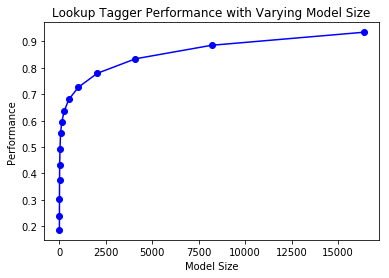

In [48]:
def performance(cfd, wordlist):
    lt = dict((word, cfd[word].max()) for word in wordlist)
    baseline_tagger = nltk.UnigramTagger(model=lt, backoff=nltk.DefaultTagger('NN'))
    return baseline_tagger.evaluate(brown.tagged_sents(categories='news'))

def display():
    import pylab
    word_freqs = nltk.FreqDist(brown.words(categories='news')).most_common()
    words_by_freq = [w for (w, _) in word_freqs]
    cfd = nltk.ConditionalFreqDist(brown.tagged_words(categories='news'))
    sizes = 2 ** pylab.arange(15)
    perfs = [performance(cfd, words_by_freq[:size]) for size in sizes]
    pylab.plot(sizes, perfs, '-bo')
    pylab.title('Lookup Tagger Performance with Varying Model Size')
    pylab.xlabel('Model Size')
    pylab.ylabel('Performance')
    pylab.show()
    
display()

Observe that performance initially increases rapidly as the model size grows, eventually reaching a plateau, when large increases in model size yield little improvement in performance. (This example used the pylab plotting package, discussed in 4.8.)

#### Evaluation
In the above examples, you will have noticed an emphasis on accuracy scores. In fact, evaluating the performance of such tools is a central theme in NLP. Recall the processing pipeline in fig-sds; any errors in the output of one module are greatly multiplied in the downstream modules.

We evaluate the performance of a tagger relative to the tags a human expert would assign. Since we don't usually have access to an expert and impartial human judge, we make do instead with gold standard test data. This is a corpus which has been manually annotated and which is accepted as a standard against which the guesses of an automatic system are assessed. The tagger is regarded as being correct if the tag it guesses for a given word is the same as the gold standard tag.

Of course, the humans who designed and carried out the original gold standard annotation were only human. Further analysis might show mistakes in the gold standard, or may eventually lead to a revised tagset and more elaborate guidelines. Nevertheless, the gold standard is by definition "correct" as far as the evaluation of an automatic tagger is concerned.

> Developing an annotated corpus is a major undertaking. Apart from the data, it generates sophisticated tools, documentation, and practices for ensuring high quality annotation. The tagsets and other coding schemes inevitably depend on some theoretical position that is not shared by all, however corpus creators often go to great lengths to make their work as theory-neutral as possible in order to maximize the usefulness of their work. We will discuss the challenges of creating a corpus in 11..

## N-Gram Tagging

#### Unigram Tagging
Unigram taggers are based on a simple statistical algorithm: for each token, assign the tag that is most likely for that particular token. For example, it will assign the tag JJ to any occurrence of the word frequent, since frequent is used as an adjective (e.g. a frequent word) more often than it is used as a verb (e.g. I frequent this cafe). A unigram tagger behaves just like a lookup tagger (4), except there is a more convenient technique for setting it up, called training. In the following code sample, we train a unigram tagger, use it to tag a sentence, then evaluate:

In [50]:
brown_tagged_sents = brown.tagged_sents(categories='news')
brown_sents = brown.sents(categories='news')
unigram_tagger = nltk.UnigramTagger(brown_tagged_sents)
unigram_tagger.tag(brown_sents[2007])

[('Various', 'JJ'),
 ('of', 'IN'),
 ('the', 'AT'),
 ('apartments', 'NNS'),
 ('are', 'BER'),
 ('of', 'IN'),
 ('the', 'AT'),
 ('terrace', 'NN'),
 ('type', 'NN'),
 (',', ','),
 ('being', 'BEG'),
 ('on', 'IN'),
 ('the', 'AT'),
 ('ground', 'NN'),
 ('floor', 'NN'),
 ('so', 'QL'),
 ('that', 'CS'),
 ('entrance', 'NN'),
 ('is', 'BEZ'),
 ('direct', 'JJ'),
 ('.', '.')]

In [51]:
unigram_tagger.evaluate(brown_tagged_sents)

0.9349006503968017

We train a UnigramTagger by specifying tagged sentence data as a parameter when we initialize the tagger. The training process involves inspecting the tag of each word and storing the most likely tag for any word in a dictionary, stored inside the tagger.

#### Separating the Training and Testing Data
Now that we are training a tagger on some data, we must be careful not to test it on the same data, as we did in the above example. A tagger that simply memorized its training data and made no attempt to construct a general model would get a perfect score, but would also be useless for tagging new text. Instead, we should split the data, training on 90% and testing on the remaining 10%:

In [52]:
size = int(len(brown_tagged_sents) * 0.9)
size

4160

In [53]:
train_sents = brown_tagged_sents[:size]
test_sents = brown_tagged_sents[size:]
unigram_tagger = nltk.UnigramTagger(train_sents)
unigram_tagger.evaluate(test_sents)

0.8121200039868434

Although the score is worse, we now have a better picture of the usefulness of this tagger, i.e. its performance on previously unseen text.

#### General N-Gram Tagging
When we perform a language processing task based on unigrams, we are using one item of context. In the case of tagging, we only consider the current token, in isolation from any larger context. Given such a model, the best we can do is tag each word with its a priori most likely tag. This means we would tag a word such as wind with the same tag, regardless of whether it appears in the context the wind or to wind.

An n-gram tagger is a generalization of a unigram tagger whose context is the current word together with the part-of-speech tags of the n-1 preceding tokens, as shown in 5.1. The tag to be chosen, tn, is circled, and the context is shaded in grey. In the example of an n-gram tagger shown in 5.1, we have n=3; that is, we consider the tags of the two preceding words in addition to the current word. An n-gram tagger picks the tag that is most likely in the given context.

![yoh](http://www.nltk.org/images/tag-context.png)

> A 1-gram tagger is another term for a unigram tagger: i.e., the context used to tag a token is just the text of the token itself. 2-gram taggers are also called bigram taggers, and 3-gram taggers are called trigram taggers.

The NgramTagger class uses a tagged training corpus to determine which part-of-speech tag is most likely for each context. Here we see a special case of an n-gram tagger, namely a bigram tagger. First we train it, then use it to tag untagged sentences:

In [54]:
bigram_tagger = nltk.BigramTagger(train_sents)
bigram_tagger.tag(brown_sents[2007])

[('Various', 'JJ'),
 ('of', 'IN'),
 ('the', 'AT'),
 ('apartments', 'NNS'),
 ('are', 'BER'),
 ('of', 'IN'),
 ('the', 'AT'),
 ('terrace', 'NN'),
 ('type', 'NN'),
 (',', ','),
 ('being', 'BEG'),
 ('on', 'IN'),
 ('the', 'AT'),
 ('ground', 'NN'),
 ('floor', 'NN'),
 ('so', 'CS'),
 ('that', 'CS'),
 ('entrance', 'NN'),
 ('is', 'BEZ'),
 ('direct', 'JJ'),
 ('.', '.')]

In [55]:
unseen_sent = brown_sents[4203]
bigram_tagger.tag(unseen_sent)

[('The', 'AT'),
 ('population', 'NN'),
 ('of', 'IN'),
 ('the', 'AT'),
 ('Congo', 'NP'),
 ('is', 'BEZ'),
 ('13.5', None),
 ('million', None),
 (',', None),
 ('divided', None),
 ('into', None),
 ('at', None),
 ('least', None),
 ('seven', None),
 ('major', None),
 ('``', None),
 ('culture', None),
 ('clusters', None),
 ("''", None),
 ('and', None),
 ('innumerable', None),
 ('tribes', None),
 ('speaking', None),
 ('400', None),
 ('separate', None),
 ('dialects', None),
 ('.', None)]

Notice that the bigram tagger manages to tag every word in a sentence it saw during training, but does badly on an unseen sentence. As soon as it encounters a new word (i.e., 13.5), it is unable to assign a tag. It cannot tag the following word (i.e., million) even if it was seen during training, simply because it never saw it during training with a None tag on the previous word. Consequently, the tagger fails to tag the rest of the sentence. Its overall accuracy score is very low:

In [56]:
bigram_tagger.evaluate(test_sents)

0.10206319146815508

As n gets larger, the specificity of the contexts increases, as does the chance that the data we wish to tag contains contexts that were not present in the training data. This is known as the sparse data problem, and is quite pervasive in NLP. As a consequence, there is a trade-off between the accuracy and the coverage of our results (and this is related to the precision/recall trade-off in information retrieval).

#### Combining Taggers
One way to address the trade-off between accuracy and coverage is to use the more accurate algorithms when we can, but to fall back on algorithms with wider coverage when necessary. For example, we could combine the results of a bigram tagger, a unigram tagger, and a default tagger, as follows:

1. Try tagging the token with the bigram tagger.
2. If the bigram tagger is unable to find a tag for the token, try the unigram tagger.
3. If the unigram tagger is also unable to find a tag, use a default tagger.

Most NLTK taggers permit a backoff-tagger to be specified. The backoff-tagger may itself have a backoff tagger:

In [57]:
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)
t2.evaluate(test_sents)

0.8452108043456593

#### Tagging Unknown Words
Our approach to tagging unknown words still uses backoff to a regular-expression tagger or a default tagger. These are unable to make use of context. Thus, if our tagger encountered the word blog, not seen during training, it would assign it the same tag, regardless of whether this word appeared in the context the blog or to blog. How can we do better with these unknown words, or out-of-vocabulary items?

A useful method to tag unknown words based on context is to limit the vocabulary of a tagger to the most frequent n words, and to replace every other word with a special word UNK using the method shown in 3. During training, a unigram tagger will probably learn that UNK is usually a noun. However, the n-gram taggers will detect contexts in which it has some other tag. For example, if the preceding word is to (tagged TO), then UNK will probably be tagged as a verb.

#### Storing Taggers
Training a tagger on a large corpus may take a significant time. Instead of training a tagger every time we need one, it is convenient to save a trained tagger in a file for later re-use. Let's save our tagger t2 to a file t2.pkl.

In [58]:
from pickle import dump

output = open('t2.pkl', 'wb')
dump(t2, output, -1)
output.close()

In [59]:
#Now, in a separate Python process, we can load our saved tagger.
from pickle import load
input = open('t2.pkl', 'rb')
tagger = load(input)
input.close()

In [60]:
text = """The board's action shows what free enterprise
     is up against in our complex maze of regulatory laws ."""

tokens = text.split()
tagger.tag(tokens)

[('The', 'AT'),
 ("board's", 'NN$'),
 ('action', 'NN'),
 ('shows', 'NNS'),
 ('what', 'WDT'),
 ('free', 'JJ'),
 ('enterprise', 'NN'),
 ('is', 'BEZ'),
 ('up', 'RP'),
 ('against', 'IN'),
 ('in', 'IN'),
 ('our', 'PP$'),
 ('complex', 'JJ'),
 ('maze', 'NN'),
 ('of', 'IN'),
 ('regulatory', 'NN'),
 ('laws', 'NNS'),
 ('.', '.')]

#### Performance Limitations
What is the upper limit to the performance of an n-gram tagger? Consider the case of a trigram tagger. How many cases of part-of-speech ambiguity does it encounter? We can determine the answer to this question empirically:

In [61]:
cfd = nltk.ConditionalFreqDist(
            ((x[1], y[1], z[0]), z[1])
            for sent in brown_tagged_sents
            for x, y, z in nltk.trigrams(sent))

ambiguous_contexts = [c for c in cfd.conditions() if len(cfd[c]) > 1]
sum(cfd[c].N() for c in ambiguous_contexts) / cfd.N()

0.049297702068029296

Thus, one out of twenty trigrams is ambiguous [EXAMPLES]. Given the current word and the previous two tags, in 5% of cases there is more than one tag that could be legitimately assigned to the current word according to the training data. Assuming we always pick the most likely tag in such ambiguous contexts, we can derive a lower bound on the performance of a trigram tagger.

Another way to investigate the performance of a tagger is to study its mistakes. Some tags may be harder than others to assign, and it might be possible to treat them specially by pre- or post-processing the data. A convenient way to look at tagging errors is the confusion matrix. It charts expected tags (the gold standard) against actual tags generated by a tagger:

In [62]:
test_tags = [tag for sent in brown.sents(categories='editorial')
             for (word, tag) in t2.tag(sent)]

gold_tags = [tag for (word, tag) in brown.tagged_words(categories='editorial')]

print(nltk.ConfusionMatrix(gold_tags, test_tags))   

           |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            